<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ознакомление,-подготовка-данных-для-обучения-моделей" data-toc-modified-id="Ознакомление,-подготовка-данных-для-обучения-моделей-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ознакомление, подготовка данных для обучения моделей</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-разделу-1" data-toc-modified-id="Вывод-по-разделу-1-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод по разделу 1</a></span></li></ul></li><li><span><a href="#Обучение.-Модели-LogisticRegression,-RandomForestClassifier-и-LGBMClassifier" data-toc-modified-id="Обучение.-Модели-LogisticRegression,-RandomForestClassifier-и-LGBMClassifier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение. Модели LogisticRegression, RandomForestClassifier и LGBMClassifier</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Тестирование-выбранной-модели" data-toc-modified-id="Тестирование-выбранной-модели-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тестирование выбранной модели</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Цель проекта: пользователи интернет магазина могут редактировать и дополнять описания товаров.  
Необходимо разработать инструмент, который будет классифицировать комментарии на позитивные и негативные и отправлять их на модерацию.
  
Задача: построить модель со значением метрики качества F1 не меньше 0.75  
  
Имеющиеся данные: набор данных с разметкой о токсичности правок. Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак"

## Ознакомление, подготовка данных для обучения моделей

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
import spacy

from nltk.corpus import stopwords as nltk_stopwords
from lightgbm import LGBMClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
#загрузка данных
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
#первые пять строк набора данных
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
#столбец Unnamed: 0 не имеет смысловой нагрузки для решения поставленной задачи и дублирует индекс, удалим его
data = data.drop('Unnamed: 0', axis=1)

In [5]:
#общая информация
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
#проверка на дубликаты
data.duplicated().mean()

0.0

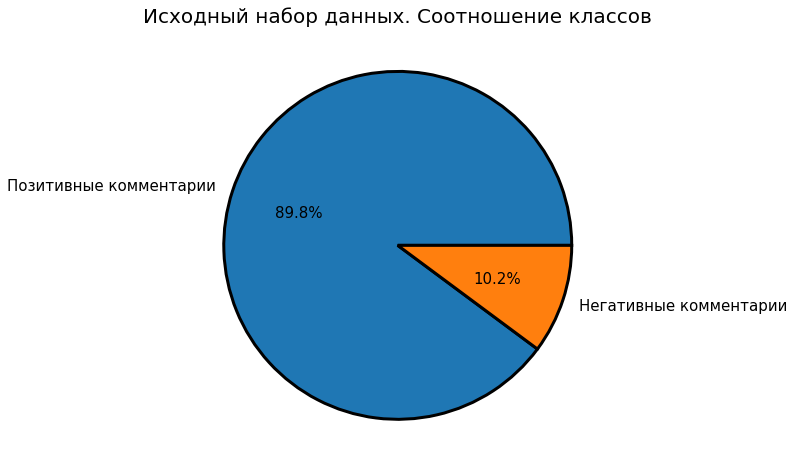

In [7]:
#посмотрим соотношение долей классов в наборе данных
plt.figure(figsize=(8,8))
plt.pie(data['toxic'].value_counts(normalize=True), autopct='%1.1f%%', labels=['Позитивные комментарии',\
        'Негативные комментарии'], wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'}, textprops={'fontsize': 15})

plt.title('Исходный набор данных. Соотношение классов', size = 20)
plt.show()

In [8]:
#для ускорения отладки кода ограничим количество данных. При подготовке работы параметры подбирались на сокращеной выборке
#В конце была проведена проверка на полном наборе данных
#data = data.sample(10000).reset_index(drop=True)

Подготовим функцию. Функция принимает на вход текст и выполняет с ним следующие действия:
1. очищает текст от ссылок 
2. оставляет в тексте только латинские символы и пробелы
3. Приводит текст к нижнему регистру
4. устраняет лишние пробелы комбинацией функций join() и split()
5. переобразует текст в лемматизированную строку
6. в return возвращает строку из лемм функцией join()

In [9]:
disabled_pipes = [ "parser",  "ner"]
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)


def clear_lemm_text(text):
    text = re.sub(r'https?\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    clear_text = ' '.join(text.split()) 
    lemm_list = nlp(clear_text)
    lemm_text = ' '.join([token.lemma_ for token in lemm_list])
    return lemm_text

In [10]:
#проведем проверку правильности лемматизации
sentence = 'on the website www.good_bat.ru and https://yandex.ru it says: "The striped bats are hanging on their feet for best"'
print(clear_lemm_text(sentence))

on the website and it say the stripe bat be hang on their foot for good


In [11]:
# %%time
# #Создадим столбец 'lemm_text', применив функцию к столбцу 'text'
# data['lemm_text'] = data['text'].apply(clear_lemm_text)

In [12]:
%%time
data['lemm_text'] = data['text'].progress_apply(clear_lemm_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 17min 8s, sys: 6.61 s, total: 17min 14s
Wall time: 17min 42s


In [13]:
#столбец 'text' удалим
data = data.drop('text', axis=1)

In [14]:
#первые пять строк набора данных
data.head(5)

,toxic,lemm_text
0,0,explanation why the edit make under my usernam...
1,0,d aww he match this background colour I m seem...
2,0,hey man I m really not try to edit war it s ju...
3,0,more I can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


In [15]:
#создадим features и target
features = data.drop(['toxic'], axis=1)
target = data['toxic']

In [16]:
# укажем в параметрах stratify=target для сохранения баланса классов в обучающей и тестовой выборке
features_train, features_test, target_train, target_test = train_test_split(
    features['lemm_text'], target, test_size=0.1, random_state=12345, stratify=target)

In [17]:
#загрузим список стоп-слов. Функции stopwords.words() передадим аргумент 'english' (стоп-слова из английского языка)
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Вывод по разделу 1

В разделе 1 сделано следующее:  
1. проведено ознакомление с данными;  
2. удален столбец Unnamed: 0, не имеющий смысловой нагрузки для решения поставленной задачи;  
3. проведена проверка на дубликаты;  
4. выявлен дисбаланс классов в наборе данных (89.8% - положительных комментариев, 10.2% - негативных комментариев);  
5. Создан столбец 'lemm_text', содержащий лемматизированные строки с латинскими символами (приведенные к нижнему регистру, очищенные от ссылок и лишних пробелов);  
6. Столбец 'toxic' удален;  
7. данные разбиты на треннеровочную и тестовую выборки;  
8. Загружен список стоп-слов.  

Данные подготовлены для использования в моделях ML

## Обучение. Модели LogisticRegression, RandomForestClassifier и LGBMClassifier

Для предотвращения утечки статистики (утечки признака) при крос-валидации, связанной с векторизацией текстов, будем использовать конвейер pipeline  
  
С помощью TfidfVectorizer создадим признаки cо значениями TF-IDF (величина, характеризующая количество упоминаний слова в отдельном комментарии и частоту употребления слова во всём корпусе).
  
В аргументы для TfidfVectorizer передадим список стоп-слов (слов не несущих смысловую нагрузку).
  
С помощью аргумента ngram_range для TfidfVectorizer зададим необходимое количество n-грамм (ngram_range (1, 1) - только униграммы, (1, 2) - униграммы и биграммы).
  
С помощью кросс-валидации определим количество n-грамм, обеспечивающее наибольшее значение метрики F1 и лучшие гиперпараметры модели-классификатора.
  
Протестируем выбранную модель  

### LogisticRegression

In [18]:
#Принимая во внимание дисбаланс классов применим параметр class_weight='balanced' для автоматической настройки весов
lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('lr', LogisticRegression(random_state=12345, class_weight='balanced', max_iter=500))])

In [19]:
params_lr = {'tfidf__ngram_range': ((1, 1), (1, 2)),
             'lr__C': [10, 30]}

Код в следующей ячейке закомментирован для экономии времени. Результат его выполнения приведен в ячейке ниже

In [20]:
# %%time
# lr_grid = GridSearchCV(estimator=lr_pipe, param_grid=params_lr, cv=3, scoring='f1', n_jobs=-1)
# lr_grid.fit(features_train, target_train)
# print('Лучшие гиперпараметры', lr_grid.best_params_)
# print('Максимальное значение F1 = ', lr_grid.best_score_)

Лучшие гиперпараметры {'lr__C': 30, 'tfidf__ngram_range': (1, 2)}  
Максимальное значение F1 =  0.7851441247795522  
CPU times: user 18min 12s, sys: 19min 15s, total: 37min 27s  
Wall time: 37min 30s  

### RandomForestClassifier

In [21]:
#Принимая во внимание дисбаланс классов применим параметр class_weight='balanced' для автоматической настройки весов
rf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('rf', RandomForestClassifier(class_weight = 'balanced', random_state = 1234))])

In [22]:
params_rf = {'tfidf__ngram_range': ((1, 1), (1, 2)),
             'rf__max_depth': [50, 100]}

Код в следующей ячейке закомментирован для экономии времени. Результат его выполнения приведен в ячейке ниже

In [23]:
# %%time
# rf_grid = GridSearchCV(estimator=rf_pipe, param_grid=params_rf, cv=3, scoring='f1', n_jobs=-1)
# rf_grid.fit(features_train, target_train)
# print('Лучшие гиперпараметры', rf_grid.best_params_)
# print('Максимальное значение F1 = ', rf_grid.best_score_)

Лучшие гиперпараметры {'rf__max_depth': 100, 'tfidf__ngram_range': (1, 1)}  
Максимальное значение F1 =  0.5553147400630544  
CPU times: user 38min 13s, sys: 13.9 s, total: 38min 27s  
Wall time: 38min 28s  

### LGBMClassifier

In [24]:
lgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('lgb', LGBMClassifier(random_state=12345))])

In [25]:
params_lgb = {
  'tfidf__ngram_range': ((1, 1), (1, 2)),
  'lgb__max_depth': [-1, 10]}

Код в следующей ячейке закомментирован для экономии времени. Результат его выполнения приведен в ячейке ниже

In [26]:
# %%time
# lgb_grid = GridSearchCV(estimator=lgb_pipe, param_grid=params_lgb, cv=3, scoring='f1', n_jobs=-1, refit=False)
# lgb_grid.fit(features_train, target_train)
# print('Лучшие гиперпараметры', lgb_grid.best_params_)
# print('Максимальное значение F1 = ', lgb_grid.best_score_)

Лучшие гиперпараметры {'lgb__max_depth': -1, 'tfidf__ngram_range': (1, 2)}  
Максимальное значение F1 =  0.7586392540341852  
CPU times: user 25min 55s, sys: 353 ms, total: 25min 56s  
Wall time: 26min  

### Тестирование выбранной модели

Лучший результат показала модель LogisticRegression(C=30, class_weight='balanced', max_iter=500, random_state=12345).  

Лучшее значение аргумента ngram_range в TfidfVectorizer = (1, 2) - n-граммы, содержащие одно и два слова после удаления стоп-слов.  
  
Проведем тестирование модели на тестовой выборке

In [27]:
lr_best_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words=stopwords)),
    ('lr', LogisticRegression(C=30, class_weight='balanced', max_iter=500, random_state=12345))])

In [28]:
%%time
lr_best_pipe.fit(features_train, target_train)

CPU times: user 4min 14s, sys: 2min 13s, total: 6min 27s
Wall time: 6min 29s


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('lr',
                 LogisticRegression(C=30, class_weight='balanced', max_iter=500,
                                    random_state=12345))])

In [29]:
%%time
predicted = lr_best_pipe.predict(features_test)

CPU times: user 1.69 s, sys: 8.93 ms, total: 1.7 s
Wall time: 1.71 s


In [30]:
print('Значение F1 на тестовой выборке = ', f1_score(predicted, target_test))

Значение F1 на тестовой выборке =  0.8022457891453524


In [31]:
print('Значение accuracy на тестовой выборке = ', accuracy_score(predicted, target_test))

Значение accuracy на тестовой выборке =  0.9602008788449466


## Общий вывод

Для достижения цели классификации комментариев на позитивные и негативные со значением метрики качества F1 не меньше 0.75 было выполнено следующее.

1) В разделе 1:

- проведено ознакомление с данными;
- удален столбец Unnamed: 0;
- проведена проверка на дубликаты;
- выявлен дисбаланс классов в наборе данных;
- Создан столбец 'lemm_text', содержащий лемматизированные строки. Столбец 'toxic' удален;
- данные разбиты на треннеровочную и тестовую выборки.

2) В разделе 2 были рассмотрены три модели: LogisticRegression, RandomForestClassifier и LGBMClassifier.   
Лучшая модель определена по максимальному значению метрики F1 (0.785) - LogisticRegression(C=30, class_weight='balanced', max_iter=500, random_state=12345)

Выбранная модель была протестирована на тестовой выборке. Значение F1 на тестовой выборке =  0.7937

Полученный для модели результат удовлетворяет поставленной задаче.